In [26]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
# style.use('fivethirtyeight')
# sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16


Using TensorFlow backend.


In [27]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)

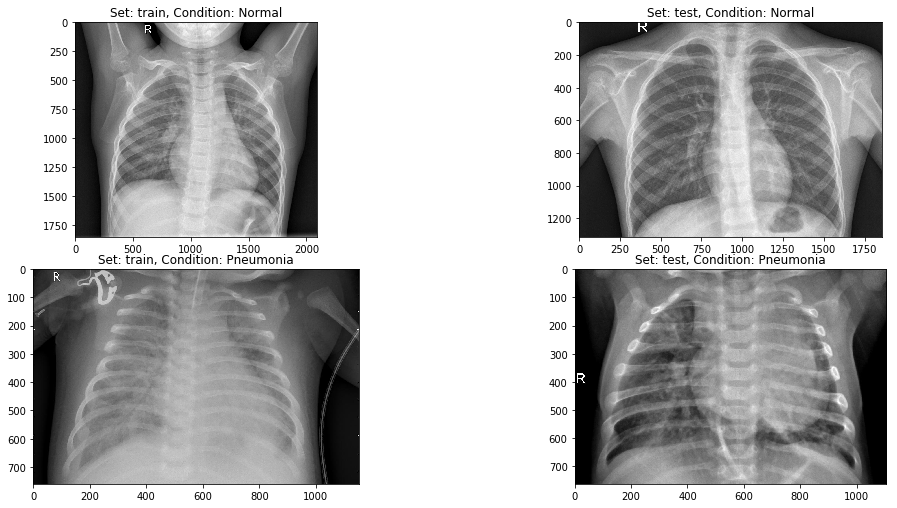

In [4]:
input_path = './chest_xray/'

fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train',  'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [5]:
input_path = './chest_xray/'

for _set in ['train', 'test', 'val']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1108, pneumonia images: 2992
Set: test, normal images: 238, pneumonia images: 641
Set: val, normal images: 237, pneumonia images: 641


In [6]:
import numpy as np
from keras import models, layers
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from capsnetKeras.capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D #Import layers for the model
from keras.layers import Dropout, Flatten, Dense 
from keras.models import Sequential #Our model will be Sequential


In [7]:
import keras.layers 

model = Sequential()
input_shape=(200,200,3)
number_of_classes = 2


x = layers.Input(shape=input_shape)
OSmodel = Conv2D(filters=32,kernel_size=(3,3),activation='relu', name="FirstLayer")(x)
OSmodel = MaxPooling2D(pool_size=(2, 2))(OSmodel)

OSmodel = Conv2D(filters=64,kernel_size=(3,3),activation='relu', name="SecondLayer")(OSmodel)
OSmodel = MaxPooling2D(pool_size=(2, 2))(OSmodel)

OSmodel = Conv2D(filters=128,kernel_size=(3,3),activation='relu', name="ThirdLayer")(OSmodel)
OSmodel = MaxPooling2D(pool_size=(2, 2))(OSmodel)

OSmodel = Conv2D(filters=128,kernel_size=(3,3),activation='relu', name="FourthLayer")(OSmodel)
OSmodel = MaxPooling2D(pool_size=(2, 2))(OSmodel)

conv1 = layers.Conv2D(128, (3, 3), activation='relu', name="FifthLayer")(OSmodel)

'''
The second layer is a Primary Capsule layer resulting from 128×7×7 convolutions with strides of 1.
'''
primaryCaps = PrimaryCap(inputs=conv1, dim_capsule=8, n_channels=16, kernel_size=3, strides=1, padding='valid')
'''
Final capsule layer includes 2 capsules, referred to as “Class Capsules,’ ’one for each of 2 classes. The dimension of these capsules is 16.
'''
capLayer2 = CapsuleLayer(num_capsule=2, dim_capsule=16, routings=8, name="SixthLayer")(primaryCaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its
# length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(capLayer2)


# Decoder network.
y = layers.Input(shape=(number_of_classes,))
# The true label is used to mask the output of capsule layer. For training
masked_by_y = Mask()([capLayer2, y])
# Mask using the capsule with maximal length. For prediction
masked = Mask()(capLayer2)


# Shared Decoder model in training and prediction
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(128, activation='relu',input_dim=16 * number_of_classes))
decoder.add(layers.Dense(256, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

# Models for training and evaluation (prediction)
train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])

print(train_model.summary())

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
FirstLayer (Conv2D)             (None, 198, 198, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 99, 99, 32)   0           FirstLayer[0][0]                 
__________________________________________________________________________________________________
SecondLayer (Conv2D)            (None, 97, 97, 64)   18496       max_pooling2d_1[0][0]            
______________________________________________

In [8]:
def create_generator(data_directory, batch_size=16):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range = 30, 
                                       width_shift_range = 0.2, 
                                       height_shift_range = 0.2, 
                                       shear_range = 0.2,
                                       zoom_range=0.2, 
                                       horizontal_flip=True)
    image_resize_height = 200
    image_resize_width = 200

    generator = train_datagen.flow_from_directory(
        data_directory,
        target_size=(image_resize_height, image_resize_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True)

    while 1:
        x_batch, y_batch = generator.next()
        yield ([x_batch, y_batch], [y_batch, x_batch])


In [9]:
def create_test_generator(data_directory, batch_size=16):
    train_datagen = ImageDataGenerator(rescale=1./255)
    image_resize_height = 200
    image_resize_width = 200

    generator = train_datagen.flow_from_directory(
        data_directory,
        target_size=(image_resize_height, image_resize_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True)

    while 1:
        x_batch, y_batch = generator.next()
        yield ([x_batch, y_batch], [y_batch, x_batch])

In [10]:
input_path = './chest_xray/'

train_data_directory = input_path+'train/'
validation_data_directory = input_path+'test/'
bsize = 16

train_generator = create_generator(train_data_directory, 
                                   batch_size=bsize)

validation_generator = create_test_generator(validation_data_directory,
                                        batch_size=bsize)


In [11]:
from keras import optimizers
from keras import backend as K

train_model.compile(optimizer='rmsprop',
                    loss= 'mse',
                    metrics=['acc'])

In [12]:
checkpointer1 = ModelCheckpoint(filepath='./Models/OSCapsNetD2.hdf5', 
                               verbose=1, 
                               monitor='val_capsnet_acc', 
                               mode='max',
                               save_best_only=True) 

es2 = EarlyStopping(
    monitor='val_capsnet_loss', 
    mode='max',
    patience=100)


In [39]:
hist = train_model.fit_generator(
           train_generator, steps_per_epoch=163, 
           epochs=300, validation_data=validation_generator, 
           validation_steps=34, verbose = 1, callbacks=[checkpointer1, es2])

Epoch 1/300
Found 1757 images belonging to 2 classes.
Found 4099 images belonging to 2 classes.
163/163 [==============================] - 69s 422ms/step - loss: 0.3420 - capsnet_loss: 0.2929 - decoder_loss: 0.0492 - capsnet_acc: 0.6829 - decoder_acc: 0.3361 - val_loss: 0.2853 - val_capsnet_loss: 0.2519 - val_decoder_loss: 0.0334 - val_capsnet_acc: 0.7316 - val_decoder_acc: 0.3339

Epoch 00001: val_capsnet_acc improved from -inf to 0.73162, saving model to ./Models/OSCapsNetD2.hdf5
Epoch 2/300
163/163 [==============================] - 68s 418ms/step - loss: 0.3077 - capsnet_loss: 0.2597 - decoder_loss: 0.0479 - capsnet_acc: 0.6679 - decoder_acc: 0.3324 - val_loss: 0.2417 - val_capsnet_loss: 0.2075 - val_decoder_loss: 0.0342 - val_capsnet_acc: 0.7518 - val_decoder_acc: 0.3366

Epoch 00002: val_capsnet_acc improved from 0.73162 to 0.75184, saving model to ./Models/OSCapsNetD2.hdf5
Epoch 3/300
163/163 [==============================] - 71s 436ms/step - loss: 0.2908 - capsnet_loss: 0.2435

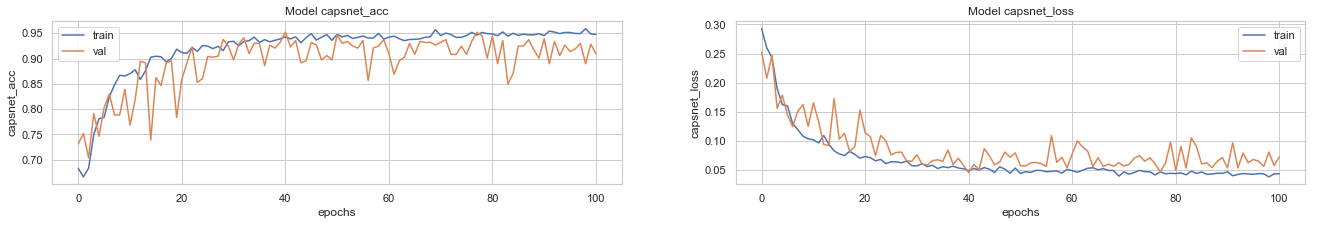

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['capsnet_acc', 'capsnet_loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

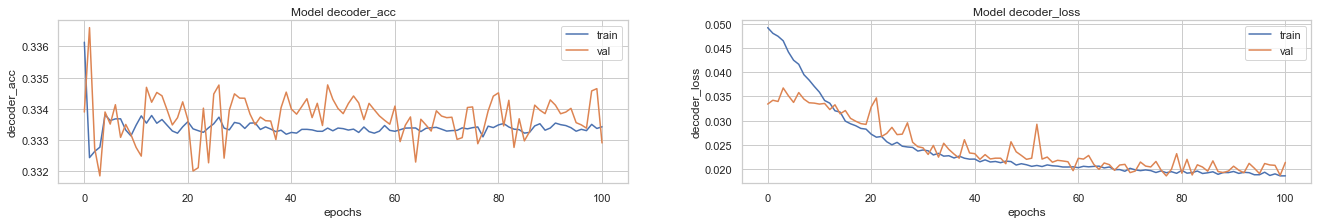

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['decoder_acc', 'decoder_loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

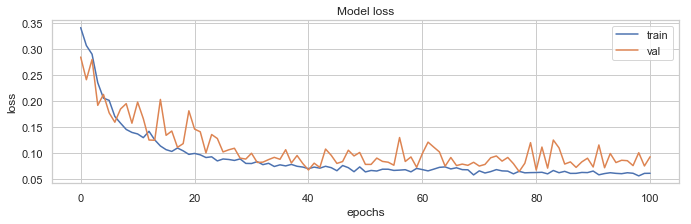

In [43]:
plt.subplots(1, 1, figsize=(10, 3))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model {}'.format('loss'))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])

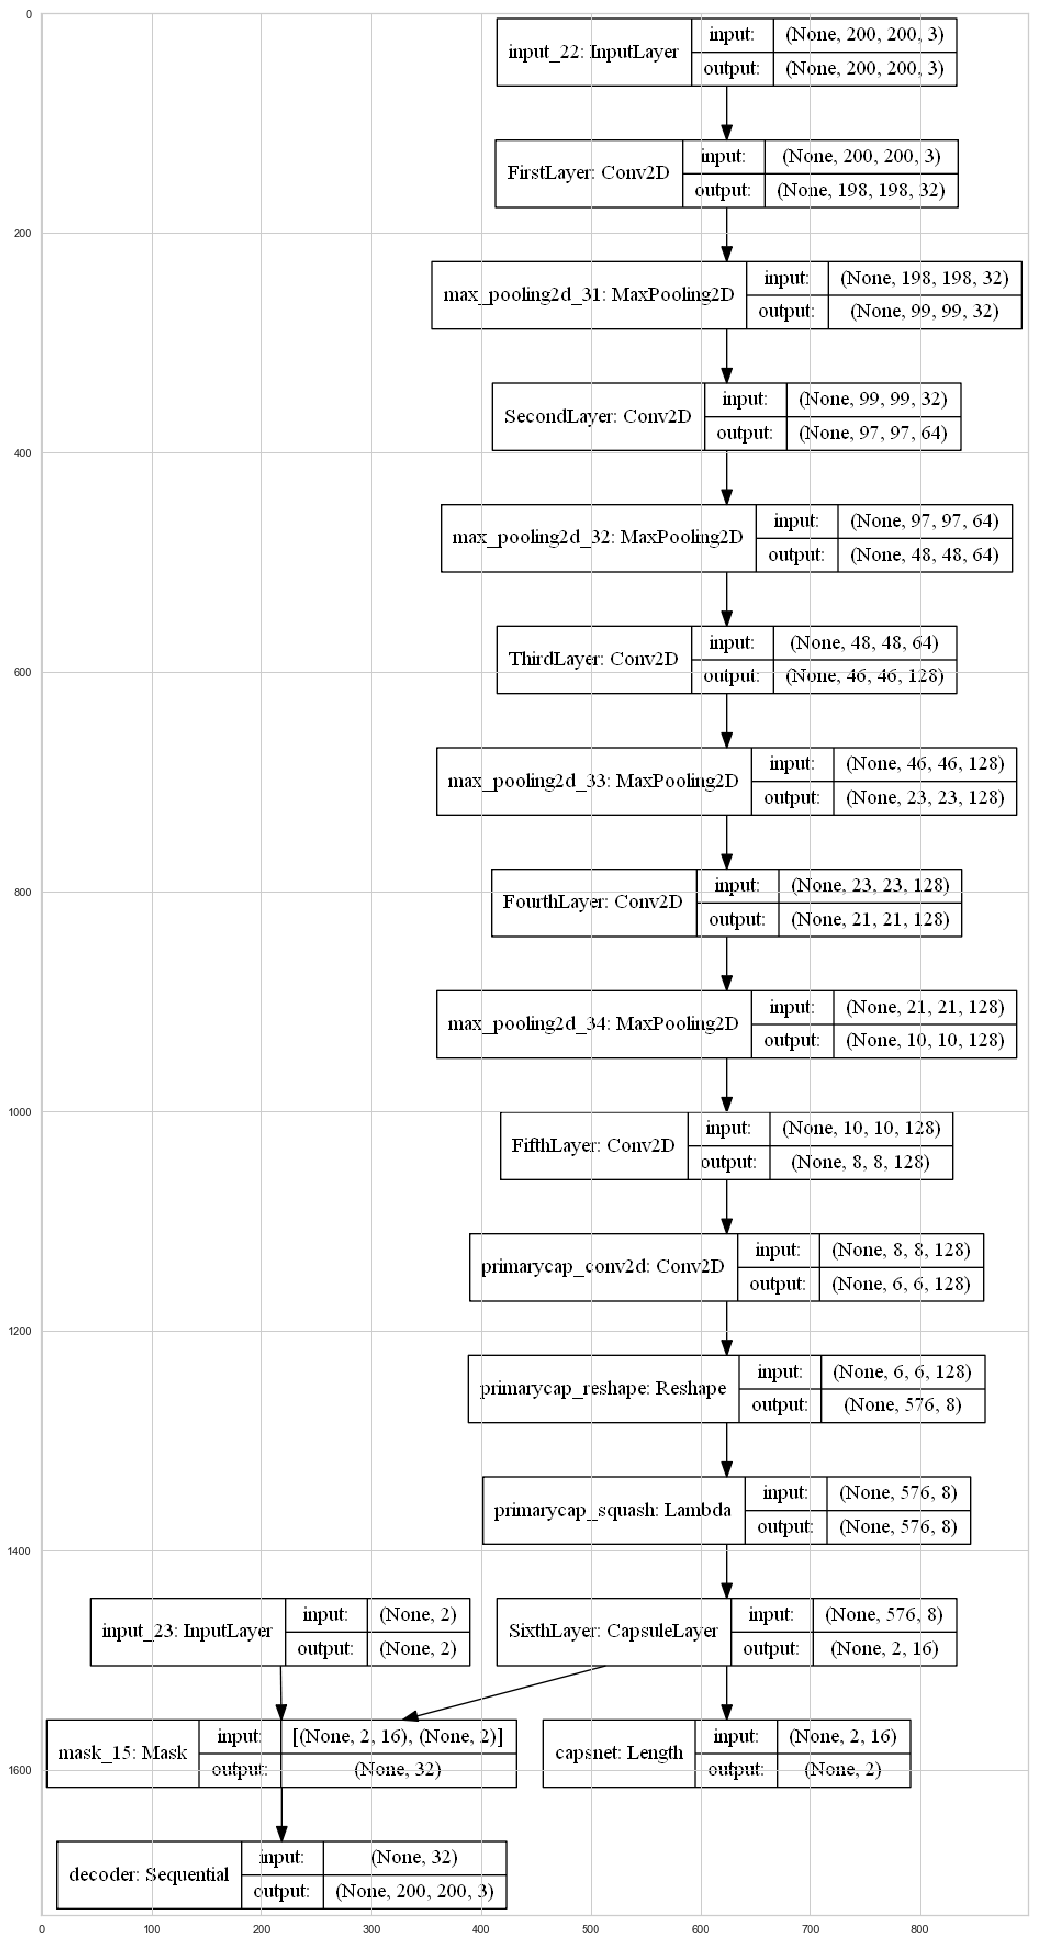

In [44]:
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plot_model(train_model, to_file='./ICC.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('./ICC.png')
plt.figure(figsize=(50,35))
imgplot = plt.imshow(img)

--------------

In [13]:
train_model.load_weights("./Models/OSCapsNetD2.hdf5")

In [14]:
def create_test_generator(data_directory, batch_size=16):
    train_datagen = ImageDataGenerator(rescale=1./255)
    image_resize_height = 200
    image_resize_width = 200

    generator = train_datagen.flow_from_directory(
        data_directory,
        target_size=(image_resize_height, image_resize_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True)

    filenames = generator.filenames
    nb_samples = len(filenames)
    print(nb_samples)
    
    while 1:
        x_batch, y_batch = generator.next()
        yield ([x_batch, y_batch], [y_batch, x_batch])
        
        


In [70]:
import itertools #create iterators for effective looping
#Plotting the confusion matrix for checking the accuracy of the model
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    print(cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
validation_data_directory = input_path+'test/'
bsize = 64

test_generator = create_test_generator(validation_data_directory,
                                        batch_size=bsize)


In [ ]:
create_test_generator(validation_data_directory,batch_size=bsize)

In [ ]:
predictions = train_model.predict_generator(test_generator, steps = 879)

[[212  25]
 [ 16 625]]


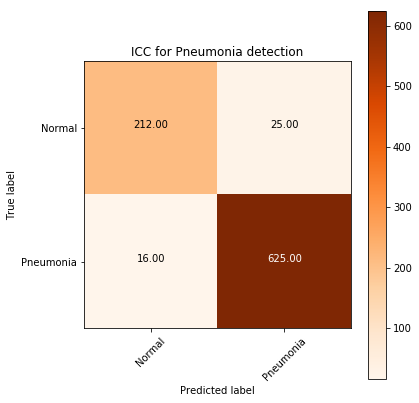

In [71]:
from sklearn.metrics import confusion_matrix
class_names=["Normal","Pneumonia"]
cnf_matrix_Arg=confusion_matrix(Y_test,predictions)
plot_confusion_matrix(cnf_matrix_Arg, classes=class_names,
                      title='ICC for Pneumonia detection')